# Regresion Lineal Múltiple
Para continuar con un modelo lineal, presentaré la regresión lineal múltiple.
Este modelo es similar al anterior pero en vez de modelar la variable dependiente $y$ con una sola variable independiente $x$, usaremos mas de una.

Matemáticamente, tendremos la siguiente expresion $\hat{y}_i = (\sum_i x_i \beta_i) + \beta_0$.
Con dos variables, esto corresponde a un plano: $\hat{y}_i = x_1 \beta_1 + x_2 \beta_2 + \beta_0$.

La idea detrás de este modelo es la misma, podemos estimar una variable a través de la ponderación lineal de otras. El criterio para evaluar al modelo es el mismo que el anterior, la pérdida cuadrática media: $\frac{1}{m} \sum_i (y_i - \hat{y}_i)^2$.

Así mismo, buscamos optimizar el costo a través del calculo del gradiente de la función.
Veamos un ejemplo de estimación de precios de casa, para obtener los datos usen el siguiente [link](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) o clonen el repo donde agregué una carpeta de datos.

Para hacer uso de algoritmos de aprendizaje de maquina, hacemos referencia a [scikit-learn](https://scikit-learn.org/stable/index.html)

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

In [2]:
entrenamiento = pd.read_csv('data/house_train.csv')

In [3]:
print(entrenamiento.shape)
entrenamiento.head(3)

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
entrenamiento.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

Consideremos 4 variables que describen una casa y suponemos que su precio se puede modelar de manera correcta con estas cuatro. Podemos representar ese conjunto de la siguiente manera:

X = [x1, x2, x3, x4]
$X \in \R^{m} \times \R^{4}$ 
donde $m$ es el número de observaciones


In [5]:
var_objetivo = 'SalePrice'
variables = ["MSSubClass", "LotShape", "YearBuilt", "YrSold"]
X = entrenamiento[variables]
y = entrenamiento[var_objetivo]
print(X.shape, y.shape)

((1460, 4), (1460,))


Las siguientes clases y funciones son de la librería `sklearn`.
Para instalarlo usa `pip install sklearn`

In [6]:
from sklearn.linear_model import LinearRegression #regresión lineal múltiple
from sklearn.metrics import mean_squared_error, r2_score #metricas para medir error
from sklearn.preprocessing import OneHotEncoder #utileria para procesar variables categoricas

La siguiente transformación es relevente e importante de comprender.
Consideremos la variable `LotShape`, esta es una variable categórica.
Es decir, sus valores representan, como su nombre lo dice, categorías.
Más aun, estas categorías no son ordenadas.
Es decir, si una observación tiene `LotShape=1` y otra tiene `LotShape=2`, esto no significa que `LotShape=1 < LotShape=2`.
Por lo tanto se hace una transformación en la cual se crean variables "dummy" para representar las distintas categorías.

In [7]:
enc_lotshape = OneHotEncoder() #instanciamos el transformador
enc_lotshape.fit(X['LotShape'].values.reshape(-1,1)) # y ajustamos los datos

OneHotEncoder(categorical_features=None, categories=None,
       dtype=<type 'numpy.float64'>, handle_unknown='error', n_values=None,
       sparse=True)

In [8]:
# con el siguiente código incluimos las variables dummies pero no lo original
transformed = enc_lotshape.transform(entrenamiento['LotShape'].values.reshape(-1,1)).toarray()
transformed_df = pd.DataFrame(transformed, columns=['var{}'.format(i) for i in range(4)]) # instanciar dataframe con un numpy array
X = X[[variable for variable in variables if variable != 'LotShape']]
X = pd.concat([X, transformed_df], axis=1)
X.head(3)

,MSSubClass,YearBuilt,YrSold,var0,var1,var2,var3
0,60,2003,2008,0.0,0.0,0.0,1.0
1,20,1976,2007,0.0,0.0,0.0,1.0
2,60,2001,2008,1.0,0.0,0.0,0.0


## Conjunto de prueba y de entrenamiento
En esta ocasión también abordaremos dos conceptos importantes, conjunto de entrenamiento y conjunto de prueba.
Usualemente se separan los datos en dos conjuntos para asegurar que el modelo no sobreajusta los datos de entrenamiento.

Es decir, se busca una generalización del fenomeno y no una descripción del conjunto de entrenamiento. 
Si el modelo tiene buen desempeño en distintas métricas en el conjunto de entrenamiento pero no en el conjunto de prueba, entonces
este no tiene una buena generalización de los datos.

In [9]:
from sklearn.model_selection import train_test_split
entrenamiento_x, prueba_x, entrenamiento_y, prueba_y = train_test_split(X, entrenamiento[var_objetivo], test_size=0.15, random_state=42)
print(entrenamiento_x.shape, entrenamiento_y.shape, prueba_x.shape, prueba_y.shape)

((1241, 7), (1241,), (219, 7), (219,))


In [10]:
# Listos para entrenar el modelo, primero instanciamos el modelo y luego ajustamos los datos
modelo = LinearRegression()
modelo.fit(entrenamiento_x, entrenamiento_y)  # entrenamiento

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [11]:
y_hat = modelo.predict(entrenamiento_x) # estimacion o prediciónn
print(type(y_hat))
entrenamiento_x['y_hat'] = y_hat # crear columna en dataframe de prediccion
entrenamiento_x['error_absoluto'] = np.abs(entrenamiento_y - entrenamiento_x['y_hat'])
entrenamiento_x['error_cuadratico'] = np.power(entrenamiento_y - entrenamiento_x['y_hat'], 2)
entrenamiento_x['over_under'] = (entrenamiento_y - entrenamiento_x['y_hat'])
entrenamiento_x['over_under'] = entrenamiento_x['over_under'].apply(lambda x: 1 if x >= 0 else -1)
entrenamiento_x[['y_hat', 'error_absoluto','error_cuadratico', 'over_under']].describe()

<type 'numpy.ndarray'>


,y_hat,error_absoluto,error_cuadratico,over_under
count,1241.000000,1241.000000,1.241000e+03,1241.000000
mean,181017.845286,45465.297786,4.163552e+09,-0.240935
std,42719.072122,45805.562337,1.304052e+10,0.970933
min,44374.474334,90.494585,8.189270e+03,-1.000000
25%,155312.282443,16050.304793,2.576123e+08,-1.000000
50%,184976.514554,35875.543852,1.287055e+09,-1.000000
75%,217373.539974,58793.412413,3.456665e+09,1.000000
max,278928.984253,523362.127833,2.739079e+11,1.000000


Vemos que este modelo, en promedio, sobreestima el valor de la propiedad a comparación del precio original.

In [12]:
entrenamiento_x.groupby('over_under').count() / entrenamiento_x.shape[0]

,MSSubClass,YearBuilt,YrSold,var0,var1,var2,var3,y_hat,error_absoluto,error_cuadratico
over_under,,,,,,,,,,
-1,0.620467,0.620467,0.620467,0.620467,0.620467,0.620467,0.620467,0.620467,0.620467,0.620467
1,0.379533,0.379533,0.379533,0.379533,0.379533,0.379533,0.379533,0.379533,0.379533,0.379533


En la siguiente gráfica comparamos las predicciones y las observaciones reales.
Es decir, si el modelo fuera bueno, veríamos como los puntos de esta gráfica, con coordenadas (prediccion, precio real), serían cercanas a la recta identidad $y=x$.

En la figura, graficamos la recta $y=x$ con la línea azul.

In [13]:
# y ~ y_hat
import matplotlib.pyplot as plt
xid = np.linspace(0, 320000, 1000)
plt.plot(y_hat, entrenamiento_y, 'k*')
plt.plot(xid,xid)
plt.show()

<Figure size 640x480 with 1 Axes>

In [14]:
r2_score(entrenamiento_y, y_hat) 

0.3045679591096989

In [15]:
mean_squared_error(entrenamiento_y, y_hat)

4163552151.1263723

Ahora veamos que pasa con el conjunto de prueba

In [16]:
y_hat = modelo.predict(prueba_x) # estimacion o prediciónn
print(type(y_hat))
prueba_x['y_hat'] = y_hat # crear columna en dataframe de prediccion
prueba_x['error_absoluto'] = np.abs(prueba_y - prueba_x['y_hat'])
prueba_x['error_cuadratico'] = np.power(prueba_y - prueba_x['y_hat'], 2)
prueba_x['over_under'] = (prueba_y - prueba_x['y_hat'])
prueba_x['over_under'] = prueba_x['over_under'].apply(lambda x: 1 if x >= 0 else -1)
prueba_x[['y_hat', 'error_absoluto','error_cuadratico', 'over_under']].describe()

<type 'numpy.ndarray'>


,y_hat,error_absoluto,error_cuadratico,over_under
count,219.000000,219.000000,2.190000e+02,219.000000
mean,180998.254345,50054.492570,5.669346e+09,-0.296804
std,38202.892936,56377.365628,2.291060e+10,0.957126
min,58944.576571,359.926200,1.295469e+05,-1.000000
25%,156853.846651,18978.692052,3.602642e+08,-1.000000
50%,178969.739856,37634.107025,1.416326e+09,-1.000000
75%,212691.585609,62490.061784,3.905008e+09,1.000000
max,269964.474784,535854.304709,2.871398e+11,1.000000


In [17]:
prueba_x.groupby('over_under').count() / prueba_x.shape[0]

,MSSubClass,YearBuilt,YrSold,var0,var1,var2,var3,y_hat,error_absoluto,error_cuadratico
over_under,,,,,,,,,,
-1,0.648402,0.648402,0.648402,0.648402,0.648402,0.648402,0.648402,0.648402,0.648402,0.648402
1,0.351598,0.351598,0.351598,0.351598,0.351598,0.351598,0.351598,0.351598,0.351598,0.351598


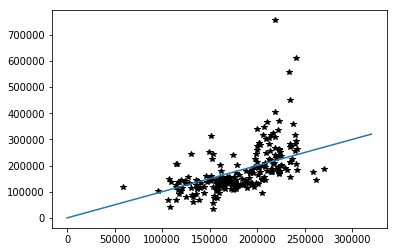

In [18]:
# y ~ y_hat
import matplotlib.pyplot as plt
xid = np.linspace(0, 320000, 1000)
plt.plot(y_hat, prueba_y, 'k*')
plt.plot(xid,xid)
plt.show()

In [19]:
r2_score(prueba_y, y_hat) 

0.30168138372916575

Veamos que el error absoluto promedio en el conjunto de entrenamiento es menor que en el conjunto de prueba, lo cual era de esperar.
Sin embargo, tanto esta métrica como la métrica $r^2$ entre los dos conjuntos es tan distante, lo cual habla de no haber sobreajustado.

# Ejercicio
Un modelo como este, siempre puede reducir (o mantener igual) el valor de la funcion a optimizar en el conjunto de entrenamiento, en este caso el error cuadrático medio, agregando una variable más. Sin embargo, esto NO pasa para el conjunto de prueba.

Trata de agregar una variable más al modelo para bajar el error del modelo en el conjunto de prueba.

Tip, existe una variable para describir cuántos baños completos hay en la casa. Esta variable serviría para aproximar el precio de forma correcta?

In [20]:
var_objetivo = 'SalePrice'
variables = ["MSSubClass", "LotShape", "YearBuilt", "YrSold"]
extra_var = # agrega el nombre de la variable pertinente aquí
variables = variables + [extra_var]
X = entrenamiento[variables]
y = entrenamiento[var_objetivo]
enc_lotshape = OneHotEncoder() #instanciamos el transformador
enc_lotshape.fit(X['LotShape'].values.reshape(-1,1)) # y ajustamos los datos

#
# Escribe el código que creas pertinente para probar que esta variable 
# ayuda a entrenar un mejor modelo

# 1. necesitas transformar la variable `LotShape`
enc_lotshape = # ?

# 2. instanciar dataframe con variables pertinentes 
transformed_df = #?
# Recordar este código
# pd.DataFrame(transformed, columns=['var{}'.format(i) for i in range(4)]) ?
# X = X[[variable for variable in variables if variable != 'LotShape']]
# X = pd.concat([X, transformed_df], axis=1)


# 3. Separar el conjunto total en entrenamiento y prueba
# Usa train_test_split


# 4. Instanciar y entrenar modelo
# Usar LinearRegression


# 5. Hacer predicciones y evaluar
# usa el metodo .predict y calcula metricas pertinentes como error absoluto
# Recuerda hacerlo para ambos conjuntos

SyntaxError: invalid syntax (<ipython-input-20-591e6ff30f1c>, line 3)